# Design eBlocks Tutorial

Welcome to the Design eBlocks tutorial! In this tutorial, we will explore the process of designing eBlocks for a gene sequence using Jupyter Notebook.

## What are eBlocks?

eBlocks are synthetic DNA sequences that are designed to introduce specific mutations into a target gene. These mutations can include single point mutations, multiple point mutations, insertions, and deletions. eBlocks are a powerful tool for studying gene function and can be used in various applications such as protein engineering, gene expression analysis, and drug discovery.

## Tutorial Overview

In this tutorial, we will cover the following topics:

1. Importing Required Modules and Packages
2. Loading and Analyzing the Gene Sequence
3. Parsing and Analyzing Mutation Data
4. Designing eBlocks
5. Visualizing eBlocks and Mutations
6. Designing Primers for eBlock Amplification

By the end of this tutorial, you will have a clear understanding of how to design eBlocks for a gene sequence and visualize the mutations introduced by these eBlocks.

Let's get started with the first step: importing the required modules and packages.

### 1. Importing Required Modules and Packages

In [13]:
import os
import sys

sys.path.append('..')
os.environ["OMP_NUM_THREADS"] = '1'  # KMeans is not parallelized, so set to 1 thread

from src.mutation import Mutation
from src.sequence import Plasmid
from src.eblocks import Eblock, EblockDesign
import biotite.sequence as seq
from src.primer import DesignPrimers
from src.plot import Plot
from src.utils import Utils, SnapGene

%reload_ext autoreload
%autoreload 2

### 2. Loading and Analyzing the Gene Sequence

The desired mutations should be added to a txt file. 
Here, we create a Mutation() object and parse the specified mutations. 

In [2]:
# Create a Mutation object and parse the input mutations from the files/ directory

mutations_file = 'files/mutations.txt'

mutation_instance = Mutation()
mutation_instance.parse_mutations(mutations_file)

# Print the mutations that were parsed
mutation_instance.print_mutations()

The selected mutations are:
	Mutation  	G432E     
	Mutation  	R436Q     
	Mutation  	I451A     
	Mutation  	A484S     
	Mutation  	K562A     
	Mutation  	I569V     
	Mutation  	L584V     
	Mutation  	T595S     
	Mutation  	D599Y     
	Mutation  	P618D     
	Mutation  	N677H     
	Mutation  	Q722V     
	Insert    	A770-PLR  
	Mutation  	D773E     
	Mutation  	K922R     
	Mutation  	E972G     
	Mutation  	W973S     
	Mutation  	Q1023R    
	Mutation  	A1031T    
	Mutation  	N1034Q    
	Mutation  	N1038T    
	Mutation  	S1046N    
	Mutation  	L1052E    
	Mutation  	V1086N    
	Mutation  	R1090A    
	Mutation  	N1096E    


Next, we read the gene sequence and the vector that contains our gene of interest.

In [3]:
# Create a Plasmid object and parse the input plasmid from the files/ directory

sequence_file = 'files/A0QX55.fasta'
vector_file = 'files/vector.dna'

sequence_instance = Plasmid()
sequence_instance.parse_vector(vector_file)
sequence_instance.parse_sequence(sequence_file)

0000


1

We also define an output directory for the generated files and create a snapgene object for visualization

In [4]:
# Create a SnapGene instance to write the eBlocks features to a snapgene file

# Set output directory
output_dir = 'output'

snapgene_instance = SnapGene(sequence_instance=sequence_instance,
                             output_dir=output_dir)

We create an eBlockDesign instance that can initiate the design of the eblocks. Here, we choose as optimization method cost_optimization that aims to use as little basepairs as possible. Another option would be to do amount_optimization, that aims to cluster as many mutations as possible together, to get the lowest number of different eBlocks

In [5]:
# Create an Eblocks object based on the input mutations and the gene sequence

design_instance = EblockDesign(mutation_instance=mutation_instance,
                               sequence_instance=sequence_instance,
                               output_dir=output_dir,
                               verbose=True,
                               cost_optimization=False,
                               amount_optimization=True)

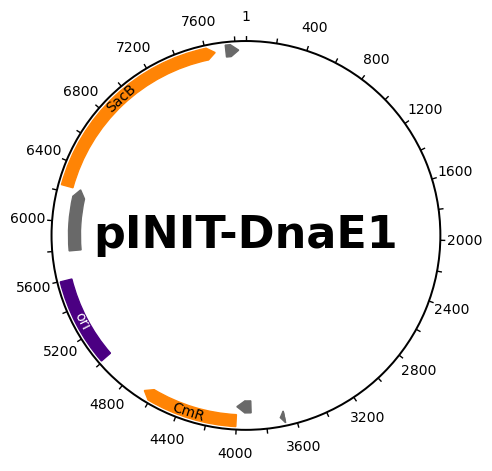

In [6]:
# Create a Plots object and check the input vector

# Create the Plot object
plot_instance = Plot(mutation_instance=mutation_instance,
                     eblocks_design_instance=design_instance,
                     sequence_instance=sequence_instance,
                     output_dir=output_dir,
                     show=True)

# Check the input vector
plot_instance.plot_vector(figsize=(5, 5));

In [7]:
# TODO Add DnaE1 gene sequence to vector
# TODO What are the other things in the vector that do not have a name?

In our vector we can see that our vector contains the SacB gene, has an origin of replication and contains a CmR (chloramphenicol) resistance marker

In [8]:

# TODO Show eBlocks in vector as well
# TODO Add plasmid visaulization of eBlock features


# from Bio import SeqIO
# from Bio.Graphics import GenomeDiagram
# from Bio.SeqFeature import SeqFeature, FeatureLocation

# # Parse the plasmid sequence
# plasmid_seq_record = SeqIO.read("plasmid_sequence.fasta", "fasta")

# # Create a GenomeDiagram object
# gd_diagram = GenomeDiagram.Diagram("Plasmid Map")

# # Add the sequence track
# gd_track = gd_diagram.new_track(1, name="Plasmid")
# gd_feature_set = gd_track.new_set()

# # Add the plasmid sequence
# gd_feature_set.add_feature(SeqFeature(FeatureLocation(0, len(plasmid_seq_record))), color="black")

# # Parse the GFF3 file to extract features
# # Assuming you have a function parse_gff3() that returns feature information
# features = parse_gff3("plasmid_features.gff3")

# # Add the features to the plasmid map
# for feature in features:
#     start = feature.start
#     end = feature.end
#     name = feature.attributes["Name"]
#     gd_feature_set.add_feature(SeqFeature(FeatureLocation(start, end)), color="blue", label=True, label_position="middle", label_size=8, label_angle=0, label_strand=0, name=name)

# # Draw the plasmid map
# gd_diagram.draw(format="linear", pagesize=(15*len(plasmid_seq_record), 400), fragments=1)
# gd_diagram.write("plasmid_map.png", "png")


In [16]:
# Run the eBlocks design and print the results

design_instance.run_design_eblocks()

Calculating relative codon frequencies, based on the selected genome id U00096 ...
Starting eBlock design ...
cluster N=2 {1: [1296, 1308, 1353, 1452, 1686, 1707, 1752, 1785, 1797, 1854, 2031, 2166, 2310, 2319, 2319], 0: [2766, 2916, 2919, 3069, 3093, 3102, 3114, 3138, 3156, 3258, 3270, 3288]}
cluster N=3 {1: [1296, 1308, 1353, 1452, 1686, 1707, 1752, 1785, 1797, 1854], 2: [2031, 2166, 2310, 2319, 2319], 0: [2766, 2916, 2919, 3069, 3093, 3102, 3114, 3138, 3156, 3258, 3270, 3288]}
Optimizing based on number of eBlocks ...
Lowest number of eBlocks: 2
GGT
G
G
CGC
R
R
ATC
I
I
GCG
A
A
AAG
K
K
ATC
I
I
CTG
L
L
ACG
T
T
GAC
D
D
CCG
P
P
AAC
N
N
CAG
Q
Q
GCG
A
A
GAC
D
D
AAG
K
K
GAG
E
E
TGG
W
W
CAA
Q
Q
GCG
A
A
AAC
N
N
AAC
N
N
TCA
S
S
CTC
L
L
GTC
V
V
CGC
R
R
AAT
N
N
Directory output\clones\G432E is not empty. Files might get overwritten or appended to.
eBlock-1 [1284, 2357, '#ff7f0e']
dnaE1 [13, 3568, '#d3d3d3']
G432E [1306, 1309, 'black']
Directory output\clones\R436Q is not empty. Files might get 

In [18]:
codon_table = seq.CodonTable.default_table()
codon = 'XXX'
result = codon_table[str(codon)] if str(codon) in codon_table else None
print(result)

: 

In the process, for each mutation a different eBlock is created and a .gb file is made to easily view the clone in a sequence editor. 

In [ ]:
# Now that we have designed the eblocks, we can visualize them using the Plot class

plot_instance.plot_eblocks_mutations(figure_length=20,
                                     figure_width=5)

In [11]:
# TODO Describe the eblocks here, what you can see with each color etc

In [ ]:
# Each type of mutations (insertions, deletions, substitutions) is represented by a different color, you can see the legend below

plot_instance.plot_mutation_legend()

In [ ]:
# To see how many mutations can be made in each eBlock, we can plot a histogram

plot_instance.plot_histogram_mutations()

In [ ]:
for eblock, mutation in design_instance.eblocks.items():
    print(f"{eblock}: {mutation}")

In [15]:
# TODO Do some explanation here

In [16]:
# TODO Save the eblocks to a file

In [17]:
# TODO (At the end of tutorial) Remake the eBlocks but optimize for amount of eBlocks

In [18]:
# Create a primer design object and run the primer design process for IVA primers to amplify the eblocks

primers_instance = DesignPrimers(mutation_instance=mutation_instance,
                                 eblocks_design_instance=design_instance,
                                 sequence_instance=sequence_instance, 
                                 output_dir=output_dir,
                                 snapgene_instance=snapgene_instance)

primers_instance.run_design()

In [ ]:
59 - 14

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

# TODO AT THE END OF THE TURORIAL CREATE A PDF WITH ALL THE PLOTS AND THE SEQUENCES

# TODO TRY RUNNING TESTS FROM COMMAND LINE AS WELL AND SEE IF THIS WORKS

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted